In [1]:
%reload_ext autoreload
%autoreload 2

# Competition page
https://www.kaggle.com/c/tweet-sentiment-extraction

## Using following notebooks for inspiration

- https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

In [6]:
def read_data(datadir):
    train = pd.read_csv(os.path.join(datadir, "train.csv"))
    test = pd.read_csv(os.path.join(datadir, "test.csv"))
    sample_submission = pd.read_csv(os.path.join(datadir, "sample_submission.csv"))

    return (train, test, sample_submission)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import numpy as np

import nltk
from nltk.corpus import stopwords
from collections import Counter

# Reading data

In [8]:
datadir = "../data"
train, test, sample = read_data(datadir)

### Sample of `train` dataset

In [ ]:
train.head()

### Head of `test` dataset

In [ ]:
test.head()

### Head of `sample_submission`

In [ ]:
sample.head()

# Row counts

In [ ]:
print(f"Records in train = {train.index.size:6,}")
print(f"Records in test  = {test.index.size:6,}")

### Proportion of different sentiments
Proportions are similar between train and test datasets with neutral sentiment as the dominant one

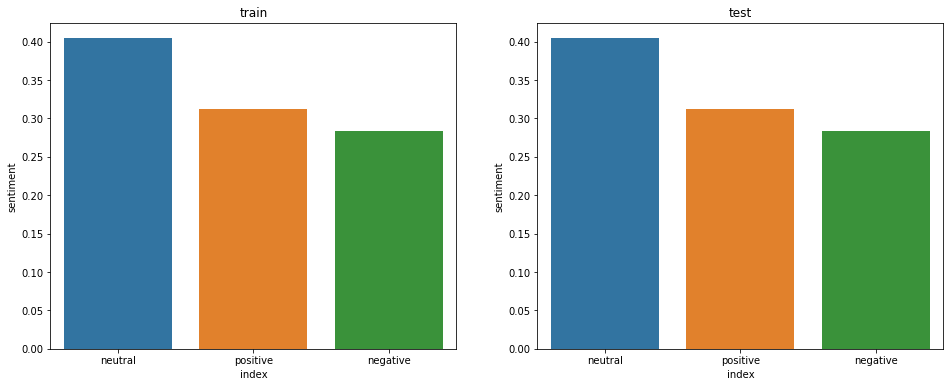

In [87]:
figsize=(16, 6)

f, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)

for ax, data, title in zip(axes, (train, test), ("train", "test")):
    (train
     .sentiment
     .value_counts(normalize=True)
     .reset_index()
     .pipe((sns.barplot, "data"), x="index", y="sentiment", ax=ax)
    )
    ax.set_title(title)

# Sentence lengths (letters)

### Distribution of lengths of the `text` and `selected_text` strings
While the distribution of `text` field is fairly uniform, the distribution of `selected_text` is skewed to the right

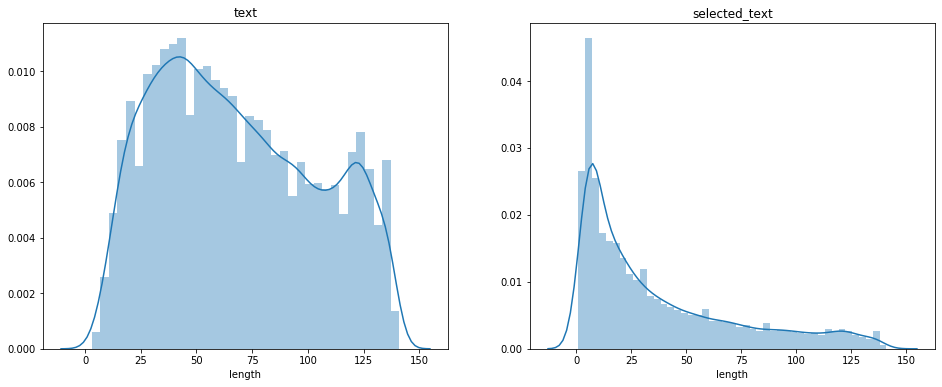

In [88]:
f, axes = plt.subplots(1, 2, figsize=figsize)

for ax, col in zip(axes, ("text", "selected_text")):
    (train
     .assign(
         length=lambda x: x.apply(lambda x: len(str(x[col])), axis=1),
     )
     .length
     .pipe((sns.distplot), ax=ax, label=col)
    )
    ax.set_title(col)

### Here, we see the distributions broken down by sentiment
The distribution for neutral sentiment for `selected_text` is interesting that it isn't positively skewed but more uniform like the distributions of the `text`

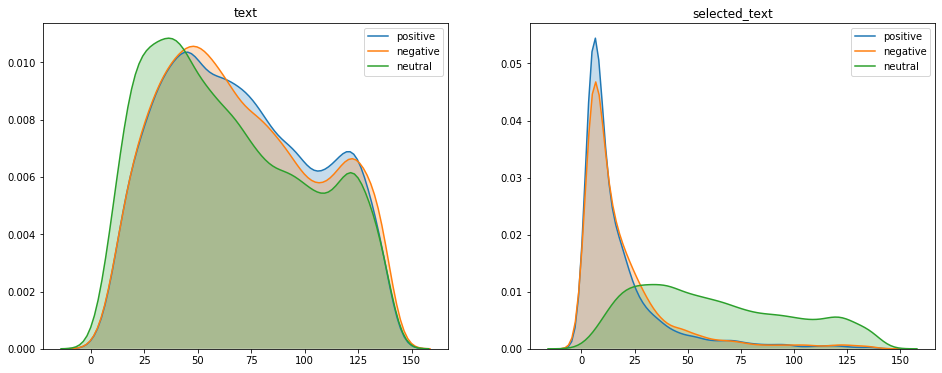

In [89]:
f, axes = plt.subplots(1, 2, figsize=figsize)

for ax, col in zip(axes, ("text", "selected_text")):
    for sentiment in ("positive", "negative", "neutral"):
        (train
         .query("sentiment == @sentiment")
         .assign(
             length=lambda x: x.apply(lambda x: len(str(x[col])), axis=1),
         )
         .length
         .pipe((sns.kdeplot, "data"), ax=ax, label=sentiment, shade=True)
        )
        ax.set_title(col)

# Number of words

### Distribution of number of words of the `text` and `selected_text` strings

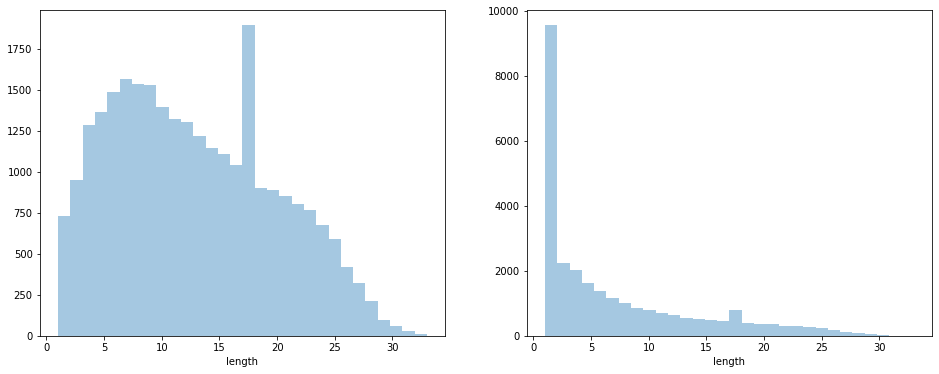

In [90]:
f, axes = plt.subplots(1, 2, figsize=figsize)

for ax, col in zip(axes, ("text", "selected_text")):
    (train
     .dropna()
     .assign(
         length=lambda x: x.apply(lambda x: len(str(x[col]).split()), axis=1),
     )
     .length
     .pipe(sns.distplot, ax=ax, label=col, kde=False, bins=30)
    )

### Here, we see the distributions broken down by sentiment
The distribution for neutral sentiment for `selected_text` is interesting that it isn't positively skewed but more uniform like the distributions of the `text`

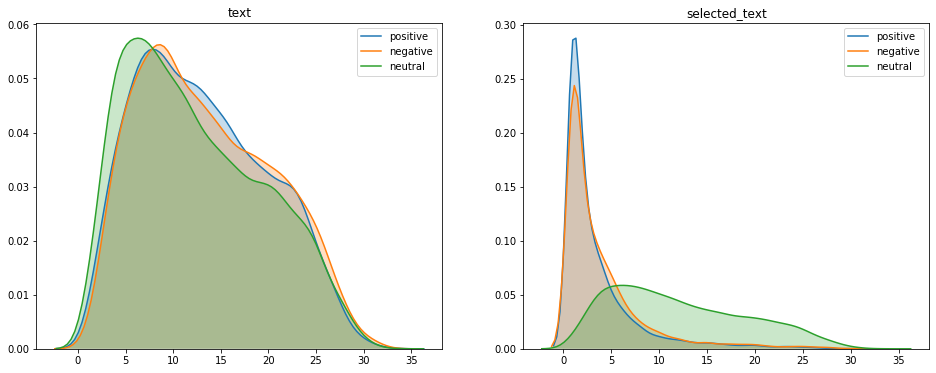

In [91]:
f, axes = plt.subplots(1, 2, figsize=figsize)

for ax, col in zip(axes, ("text", "selected_text")):
    for sentiment in ("positive", "negative", "neutral"):
        (train
         .query("sentiment == @sentiment")
         .assign(
             length=lambda x: x.apply(lambda x: len(str(x[col]).split()), axis=1),
         )
         .length
         .pipe((sns.kdeplot, "data"), ax=ax, label=sentiment, shade=True)
        )
        ax.set_title(col)

### These plots show the distributions for number of words but separated by sentiments
The distribution of `text` and `selected_text` follows a very similar pattern which indicates that the `text` as is could be used for `selected_text` if the sentiment is neutral

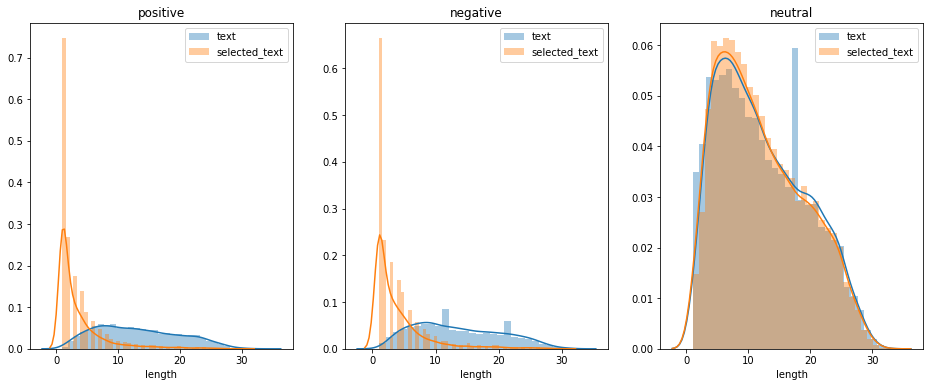

In [92]:
f, axes = plt.subplots(1, 3, figsize=figsize)

for ax, sentiment in zip(axes, ("positive", "negative", "neutral")):
    for col in ("text", "selected_text"):
        (train
         .query("sentiment == @sentiment")
         .assign(
             length=lambda x: x.apply(lambda x: len(str(x[col]).split()), axis=1),
         )
         .length
         .pipe(sns.distplot, ax=ax, label=col)
        )
        ax.set_title(sentiment)
        ax.legend()

# Jaccard similarity

In [ ]:
data_jaccard

In [ ]:
data_jaccard = (train
 .dropna()
 .assign(
     jaccard=lambda x: x.apply(lambda x: utils.jaccard_similarity(x.text, x.selected_text), axis=1),
     words_text=lambda x: x.apply(lambda x: len(x.text.split()), axis=1),
     words_st_text=lambda x: x.apply(lambda x: len(x.text.split()), axis=1)
 )
)

f, axes = plt.subplots(2, 3, figsize=(16, 8))

for num_words, row in zip((2, 100), axes):
    for sentiment, ax in zip(("positive", "negative", "neutral"), row):
        (data_jaccard
         .query("sentiment == @sentiment")
         .query("words_text <= @num_words")
         .jaccard
         .pipe(sns.distplot, ax=ax, kde=False)
        )
        ax.set_title(f"Num_words <= {num_words}, {sentiment}")
        
plt.tight_layout()

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(16, 5))

for sentiment, ax in zip(("positive", "negative", "neutral"), axes):
    (data_jaccard
     .query("sentiment == @sentiment")
     .pipe((sns.lineplot, "data"), x="words_text", y="jaccard", estimator="mean", ax=ax)
    )
    ax.set_title(f"Sentiment: {sentiment}")

plt.tight_layout()

Let's sample a few records where jaccard score is less than 1.0 for neutral sentiments. As we can see there is some behaviour that doesn't fit a pattern. 
- For some cases the only different is punctuation
- For few cases, the first letter has been removed in selected_text

One key insight is that any links have been completely removed in selected_text and hence should be filtered our during data cleaning

In [ ]:
(data_jaccard
 .query("sentiment == 'positive'")
 .query("jaccard < 1.0")
 .sort_values("jaccard")[["text", "selected_text", "jaccard", "words_text"]]
 .head(20)
)

# Top words in `text` in train dataset

In [ ]:
overall = (train
 .text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

positive = (train
 .query("sentiment == 'positive'")
 .text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

negative = (train
 .query("sentiment == 'negative'")
 .text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

neutral = (train
 .query("sentiment == 'neutral'")
 .text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

top_overall = Counter([item for row in overall for item in row if item not in stopwords.words("english")])
top_positive = Counter([item for row in positive for item in row if item not in stopwords.words("english")])
top_negative = Counter([item for row in negative for item in row if item not in stopwords.words("english")])
top_neutral = Counter([item for row in neutral for item in row if item not in stopwords.words("english")])

(
    pd.concat((
    pd.DataFrame(top_overall.most_common(20), columns=["overall", "count"]),
    pd.DataFrame(top_positive.most_common(20), columns=["positive", "count"]),
    pd.DataFrame(top_negative.most_common(20), columns=["negative", "count"]),
    pd.DataFrame(top_neutral.most_common(20), columns=["neutral", "count"])),
    axis=1)
)


# Top words in `selected_text` for train dataset

In [ ]:
overall = (train
 .selected_text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

positive = (train
 .query("sentiment == 'positive'")
 .selected_text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

negative = (train
 .query("sentiment == 'negative'")
 .selected_text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

neutral = (train
 .query("sentiment == 'neutral'")
 .selected_text
 .apply(utils.clean_text)
 .apply(lambda x: x.split())
 .values
)

top_overall = Counter([item for row in overall for item in row if item not in stopwords.words("english")])
top_positive = Counter([item for row in positive for item in row if item not in stopwords.words("english")])
top_negative = Counter([item for row in negative for item in row if item not in stopwords.words("english")])
top_neutral = Counter([item for row in neutral for item in row if item not in stopwords.words("english")])

(
    pd.concat((
    pd.DataFrame(top_overall.most_common(20), columns=["overall", "count"]),
    pd.DataFrame(top_positive.most_common(20), columns=["positive", "count"]),
    pd.DataFrame(top_negative.most_common(20), columns=["negative", "count"]),
    pd.DataFrame(top_neutral.most_common(20), columns=["neutral", "count"])),
    axis=1)
)

### Does `selected_text` contain hyperlinks

In [3]:
data_lower = (train
 .dropna()
 .assign(
     text=lambda x: x.text.apply(lambda x: x.lower()),
     selected_text=lambda x: x.selected_text.apply(lambda x: x.lower())
 )
)

search = "http://"

print(data_lower[data_lower.text.str.contains(search)].sentiment.value_counts())
data_lower[data_lower.text.str.contains(search) & data_lower.selected_text.str.contains(search)].sentiment.value_counts()


neutral     578
positive    409
negative    233
Name: sentiment, dtype: int64


neutral     344
negative      3
positive      3
Name: sentiment, dtype: int64

In [ ]:
letters = Counter([letter for sent in data_lower.text.values for letter in sent])
letters.most_common(10)

In [6]:
data_lower.query("sentiment != 'neutral'")[data_lower.text.str.contains(search) & data_lower.selected_text.str.contains(search)]

/Users/ashok/anaconda3/envs/kaggle-sentiment/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,textID,text,selected_text,sentiment
3310,cc73efff2b,this song is a slap on you face!! ? http://bl...,this song is a slap on you face!! ? http://bl...,negative
4741,a8ed4e8266,wants see my friends ;-) http://plurk.com/p/w...,wants see my friends ;-) http://plurk.com/p/w...,positive
20376,1e4dd145b3,http://twitpic.com/674p1 - this is my ohio is...,http://twitpic.com/674p1 - this is my ohio is...,negative
22853,b31ee23c1c,daddy just left.................without me ht...,daddy just left.................without me ht...,negative
24374,38a69ed9ec,add me up: http://profiles.friendster.com/amer...,add me up: http://profiles.friendster.com/amer...,positive
26430,8223259736,located & ordered a new cooker today. feel i`v...,feel i`ve got a real bargain from http://www.l...,positive


# How many words are only special characters

In [8]:
train.text

0                      I`d have responded, if I were going
1            Sooo SAD I will miss you here in San Diego!!!
2                                my boss is bullying me...
3                           what interview! leave me alone
4         Sons of ****, why couldn`t they put them on t...
                               ...                        
27476     wish we could come see u on Denver  husband l...
27477     I`ve wondered about rake to.  The client has ...
27478     Yay good for both of you. Enjoy the break - y...
27479                           But it was worth it  ****.
27480       All this flirting going on - The ATG smiles...
Name: text, Length: 27481, dtype: object

In [17]:
re.findall("[%s]" % re.escape(string.punctuation), train.iloc[0].text)

['`', ',']

In [12]:
import re
import string

In [ ]:
re.findall()

# Number of unique tokens

In [22]:
from collections import Counter
import re
import string

In [31]:
def remove_punct(text):
    return re.sub("[%s]" % re.escape(string.punctuation), "", text)

In [35]:
tokens_cleaned = [remove_punct(token.lower()) for line in train.dropna().text for token in line.strip().split()]
tokens = [token.lower() for line in train.dropna().text for token in line.strip().split()]

In [36]:
counter = Counter(tokens)
counter_cleaned = Counter(tokens_cleaned)

In [37]:
len(counter)

45433

In [38]:
len(counter_cleaned)

29166

In [39]:
len([1 for token in counter.keys() if "http" in token])

1200

In [40]:
len([1 for token in counter_cleaned.keys() if "http" in token])

1200

In [45]:
remove_punct("!!!b**!!")

'b'

In [66]:
word = "!"

In [67]:
pos_count = (train
 .dropna()
 .query("sentiment == 'positive'")
 .text.str.lower().str.contains(word)
 .sum()
)

neg_count = (train
 .dropna()
 .query("sentiment == 'negative'")
 .text.str.lower().str.contains(word)
 .sum()
)

In [68]:
print(pos_count, neg_count)

3459 1963


$$ P(W_{st} | W_{t}) = \frac{P(W_t | W_{st}) P(W_{st})}{P(W_{t})}$$

In [70]:
def calc_prob(word, sentiment):
    count_text = (train
     .dropna()
     .query("sentiment == @sentiment")
     .text.str.lower().str.contains(word)
     .sum()
    )
    
    count_st = (train
     .dropna()
     .query("sentiment == @sentiment")
     .selected_text.str.lower().str.contains(word)
     .sum()
    )
    
    return count_st/count_text

In [73]:
calc_prob("good", "negative")

0.5954545454545455

In [77]:
print(train.query("sentiment == 'positive'").iloc[0].text)
print(train.query("sentiment == 'positive'").iloc[0].selected_text)

2am feedings for the baby are fun when he is all smiles and coos
fun


In [95]:
index = 6

text = train.query("sentiment == 'positive'").iloc[index].text.lower()
st = train.query("sentiment == 'positive'").iloc[index].selected_text.lower()

print(text)
print(st)

for word in text.split():
    print(f"{word}: {calc_prob(word, 'positive'):.3f}")

i`m going home now. have you seen my new twitter design? quite....heavenly isn`****?
quite....heavenly
i`m: 0.244
going: 0.150
home: 0.189
now.: 0.123
have: 0.213
you: 0.340
seen: 0.158
my: 0.225
new: 0.169
twitter: 0.144
design?: 0.118
quite....heavenly: 1.000


error: multiple repeat at position 5

In [80]:
calc_prob(word, "positive")

0.4371205550737207

In [27]:
counter.most_common(100)

[('to', 9878),
 ('I', 8872),
 ('the', 8405),
 ('a', 6512),
 ('', 6069),
 ('my', 4949),
 ('and', 4721),
 ('you', 4382),
 ('i', 4300),
 ('is', 3733),
 ('it', 3694),
 ('in', 3640),
 ('for', 3591),
 ('of', 3107),
 ('on', 2714),
 ('me', 2674),
 ('have', 2407),
 ('that', 2379),
 ('so', 2193),
 ('with', 2040),
 ('be', 1958),
 ('but', 1948),
 ('Im', 1877),
 ('at', 1763),
 ('was', 1759),
 ('just', 1733),
 ('day', 1577),
 ('not', 1575),
 ('all', 1479),
 ('out', 1450),
 ('its', 1447),
 ('get', 1382),
 ('up', 1380),
 ('this', 1351),
 ('are', 1314),
 ('now', 1313),
 ('like', 1300),
 ('good', 1246),
 ('go', 1201),
 ('im', 1105),
 ('dont', 1088),
 ('your', 1085),
 ('do', 1066),
 ('work', 1062),
 ('too', 1023),
 ('today', 1011),
 ('no', 1005),
 ('from', 965),
 ('got', 964),
 ('going', 945),
 ('love', 929),
 ('know', 908),
 ('one', 899),
 ('time', 872),
 ('cant', 870),
 ('u', 829),
 ('really', 817),
 ('about', 817),
 ('will', 816),
 ('back', 803),
 ('there', 764),
 ('am', 762),
 ('see', 756),
 ('some',